# Audio Chunking - Ferry
### Chunk source audio files to uniform length
Last Modified December 7, 2019

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from IPython.display import Markdown, display
from IPython.display import SVG
import pandas as pd
import numpy as np
import os
import os.path
from os.path import isfile, join
from os import listdir
import pywt
import seaborn as sns
import fnmatch
import random
import sklearn
from sklearn import preprocessing
import crepe
import scipy.io.wavfile as wavfile
import pickle
np.set_printoptions(suppress=True)
import librosa
import resampy
import argparse
from pydub import AudioSegment

In [2]:
#Define folder paths
cwd = "D:\\"

cwd = os.path.join(cwd,"Ferry")
print(cwd)

puyallip = os.path.join(cwd, "original-source","puyallip")
tacoma = os.path.join(cwd, "original-source","tacoma")
os.chdir(cwd)
os.getcwd()
roots = [puyallip,tacoma]
print(roots)


D:\Ferry
['D:\\Ferry\\original-source\\puyallip', 'D:\\Ferry\\original-source\\tacoma']


### Ingest, Resample, Sort and Slice Audio Data

In [3]:
# Change from mp3 to wav file
formats_to_convert = '.mp3'

for eachroot in roots:
    for subdir, dirs, files in os.walk(eachroot):
        for file in files:
            filepath = subdir + os.sep + file
            if filepath.endswith(formats_to_convert):
                sound = AudioSegment.from_mp3(filepath)
                filepath1 = os.path.splitext(filepath)[0] + '.wav'
                sound.export(filepath1, format="wav")
                


In [4]:
# Change from m4a to wav file
formats_to_convert = '.m4a'

for eachroot in roots:
    for subdir, dirs, files in os.walk(eachroot):
        for file in files:
            filepath = subdir + os.sep + file

            if filepath.endswith(formats_to_convert):
                print(filepath)
                sound = AudioSegment.from_file(filepath)
                filepath1 = os.path.splitext(filepath)[0] + '.wav'
                sound.export(filepath1, format="wav")
            

D:\Ferry\original-source\puyallip\puyallip-20191206_141847.m4a


In [5]:
os.getcwd()

'D:\\Ferry'

In [6]:
# change sample rate to 32000
resample_rate = 32000
for root in roots:
    for subdir, dirs, files in os.walk(root):
        for file in files:
            filepath = subdir + os.sep + file
            if filepath.endswith(".wav"):
                fs, data = wavfile.read(filepath)
                y = resampy.resample(data, fs, resample_rate)
                wavfile.write(filepath, resample_rate, y)
            

D:\Ferry\original-source\puyallip\puyallip-20191206_141847.wav


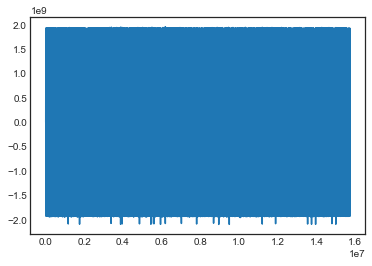

In [32]:
filename1 = "D:\Ferry\original-source\puyallip\puyallip-20191206_141847.wav"
fs, data = wavfile.read(filename1)
print(filename1)
plt.plot(data)
plt.show()

### Create lists audio files from classes

In [3]:
# Initialize vars, create lists of aircraft classes
puyallipentries = os.listdir(puyallip)
tacomaentries = os.listdir(tacoma)
alllists = [puyallipentries,tacomaentries]

listnames = ['D:\\Ferry\\original-source\\puyallip', 'D:\\Ferry\\original-source\\tacoma']

puyallip_audio = []
tacoma_audio = []
wenatchee_audio = []

puyallip_path = []
tacoma_path = []
wenatchee_path = []

iter = 0

os.chdir(cwd)
for lists in alllists:
    for file_name in lists:

        dir_name = os.path.join(listnames[iter]+os.sep+ file_name)

        if file_name.endswith('.wav'):

            if fnmatch.fnmatch(file_name, '*tacoma*'):
                tacoma_audio.append(file_name)
                tacoma_path.append(dir_name)
                
            elif fnmatch.fnmatch(file_name, '*wenatchee*'):
                wenatchee_audio.append(file_name)
                wenatchee_path.append(dir_name)

            elif fnmatch.fnmatch(file_name, '*puyallip*'):
                puyallip_audio.append(file_name)
                puyallip_path.append(dir_name)
                
    iter = iter+1         

In [4]:
os.chdir(cwd)
cwd

'D:\\Ferry'

In [5]:
random.shuffle(tacoma_audio)
random.shuffle(wenatchee_audio)
random.shuffle(puyallip_audio)


### Create train, test split of flights

In [6]:
Train_Puyallip_dir = os.path.join(cwd,"Train","Train_Puyallip")
Train_Wenatchee_dir = os.path.join(cwd,"Train","Train_Wenatchee")
Train_Tacoma_dir = os.path.join(cwd,"Train","Train_Tacoma")

Test_Puyallip_dir  = os.path.join(cwd,"Test","Test_Puyallip")
Test_Wenatchee_dir = os.path.join(cwd,"Test","Test_Wenatchee")
Test_Tacoma_dir = os.path.join(cwd,"Test","Test_Tacoma")

Train_Slices = os.path.join(cwd,"Train_Slices")
Test_Slices = os.path.join(cwd,"Test_Slices")

Train_Slices_Puyallip_dir = os.path.join(cwd,"Train_Slices","Train_Puyallip")
Train_Slices_Wenatchee_dir = os.path.join(cwd,"Train_Slices","Train_Wenatchee")
Train_Slices_Tacoma_dir = os.path.join(cwd,"Train_Slices","Train_Tacoma")

Test_Slices_Puyallip_dir  = os.path.join(cwd,"Test_Slices","Test_Puyallip")
Test_Slices_Wenatchee_dir = os.path.join(cwd,"Test_Slices","Test_Wenatchee")
Test_Slices_Tacoma_dir = os.path.join(cwd,"Test_Slices","Test_Tacoma")

directory_list = [Train_Puyallip_dir, Train_Wenatchee_dir, Train_Tacoma_dir, 
                  Test_Puyallip_dir, Test_Wenatchee_dir, Test_Tacoma_dir, Train_Slices, Test_Slices,
                 Train_Slices_Puyallip_dir, Train_Slices_Wenatchee_dir,Train_Slices_Tacoma_dir,
                 Test_Slices_Puyallip_dir, Test_Slices_Wenatchee_dir, Test_Slices_Tacoma_dir]

In [7]:

# Create target directory & all intermediate directories if don't exists
for directory in directory_list:
    try:
        os.makedirs(directory)    
        print("Directory " , directory ,  " Created ")
    except FileExistsError:
        print("Directory " , directory ,  " already exists") 

Directory  D:\Ferry\Train\Train_Puyallip  already exists
Directory  D:\Ferry\Train\Train_Wenatchee  already exists
Directory  D:\Ferry\Train\Train_Tacoma  already exists
Directory  D:\Ferry\Test\Test_Puyallip  already exists
Directory  D:\Ferry\Test\Test_Wenatchee  already exists
Directory  D:\Ferry\Test\Test_Tacoma  already exists
Directory  D:\Ferry\Train_Slices  Created 
Directory  D:\Ferry\Test_Slices  Created 
Directory  D:\Ferry\Train_Slices\Train_Puyallip  Created 
Directory  D:\Ferry\Train_Slices\Train_Wenatchee  Created 
Directory  D:\Ferry\Train_Slices\Train_Tacoma  Created 
Directory  D:\Ferry\Test_Slices\Test_Puyallip  Created 
Directory  D:\Ferry\Test_Slices\Test_Wenatchee  Created 
Directory  D:\Ferry\Test_Slices\Test_Tacoma  Created 


In [8]:
Puyallip_length = len(puyallip_audio)
Tacoma_length = len(tacoma_audio)
Wenatchee_length = len(wenatchee_audio)


In [9]:
filteredlists_dir = [
Train_Boeing_dir,Train_Embraer_dir,Train_Bombardier_dir,Train_Airbus_dir,Train_Other_dir,
Test_Boeing_dir,Test_Embraer_dir,Test_Bombardier_dir,Test_Airbus_dir,Test_Other_dir
]


Boeingsplit = int((Boeinglength/3)*2)
Embraersplit = int((Embraerlength/3)*2)
Bombardiersplit = int((Bombardierlength/3)*2)
Airbussplit = int((Airbuslength/3)*2)
Othersplit = int((Otherlength/3)*2)

Train_Boeing = Boeing700series[:Boeingsplit]
Train_Embraer = Embraer75series[:Embraersplit]
Train_Bombardier = Bombardierseries[:Bombardiersplit]
Train_Airbus = Airbusseries[:Airbussplit]
Train_Other = OtherAircraft[:Othersplit]

Test_Boeing = Boeing700series[(Boeingsplit):]
Test_Embraer = Embraer75series[(Embraersplit):]
Test_Bombardier = Bombardierseries[(Bombardiersplit):]
Test_Airbus = Airbusseries[(Airbussplit):]
Test_Other = OtherAircraft[(Othersplit):]

In [10]:
# review full paths for source
readpaths = [Boeing700series_path,
Embraer75series_path,Bombardierseries_path,Airbusseries_path,
OtherAircraft_path]
len(readpaths)

5

In [11]:
root = "D:\\aircraft-audio"
os.chdir(root)
cwd = os.getcwd()

In [12]:
print(root)

D:\aircraft-audio


In [13]:
# read sample split files and write files new target test and train directories

def _write_audio_to_train_test(Class_paths, Name_list,Class, Split):
    iter = 0
    for file in Name_list:
        if iter < Split:
            write_dir_name = os.path.join(cwd+ os.sep+ "Train"+os.sep+"Train_"+Class+os.sep+file)
        else:
            write_dir_name = os.path.join(cwd+  os.sep+ "Test"+os.sep+"Test_"+Class+os.sep+file)
        fs, data = wavfile.read(Class_paths[iter])
        wavfile.write(write_dir_name, fs, data)
        iter = iter+1
            


In [16]:
_write_audio_to_train_test(Boeing700series_path, 
                           Boeing700series,
                           "Boeing", 
                           Boeingsplit )  

In [17]:
_write_audio_to_train_test(Embraer75series_path, 
                           Embraer75series,
                           "Embraer", 
                           Embraersplit )

In [18]:
_write_audio_to_train_test(Bombardierseries_path, 
                           Bombardierseries,
                           "Bombardier", 
                           Bombardiersplit )  

In [19]:
_write_audio_to_train_test(Airbusseries_path, 
                           Airbusseries,
                           "Airbus", 
                           Airbussplit )  

In [20]:
_write_audio_to_train_test(OtherAircraft_path, 
                           OtherAircraft,
                           "Other", 
                           Othersplit )  

In [9]:
import math
resample_rate = 32000

### Slice Audio to Desired Lengths

In [10]:

def _slice_audio(source_dir, target_dir, slice_time):
    num = 0
    for subdir, dirs, files in os.walk(source_dir):
        os.chdir(source_dir)
        filepath = "" 

        for file in files:

                filepath = subdir + os.sep + file
                path_list = filepath.split(os.sep)
                path_adder = path_list[-2]
                if filepath.endswith(".wav"):
                    fs, data = wavfile.read(filepath)
                    print(filepath)
                    accounted_fs = int(resample_rate)
    
                    num_slices = math.floor(len(data) / accounted_fs)
                    print(num_slices)
                    desiredlength = math.floor(num_slices * accounted_fs)
                    print(desiredlength)
                    audio_data = data[: desiredlength]  # Trims audio array
                    sliced_audio = np.array(np.split(audio_data, num_slices))
                    print(sliced_audio.shape)

                    target_dir_specific = os.path.join(target_dir + os.sep+ path_adder)
                    os.chdir(target_dir_specific)
                    print(sliced_audio.shape)

                    for i in range(sliced_audio.shape[0]):
                        filename, file_extension = os.path.splitext(file)
                        new_fname = "{}-{}{}".format(filename,  i, file_extension)
                        if i > 0:
                            wavfile.write(new_fname, resample_rate, sliced_audio[i,:])



In [11]:
import math
_slice_audio("D:\\Ferry\\Train\\",
             "D:\\Ferry\\Train_Slices", 
             60)

D:\Ferry\Train\Train_Puyallip\puyallip-20191206_141847.wav
491
15712000
(491, 32000)
(491, 32000)
D:\Ferry\Train\Train_Tacoma\tacoma-20191206_123441.wav
515
16480000
(515, 32000)
(515, 32000)
D:\Ferry\Train\Train_Tacoma\tacoma1.wav
60
1920000
(60, 32000)
(60, 32000)
D:\Ferry\Train\Train_Tacoma\tacoma2.wav
61
1952000
(61, 32000)
(61, 32000)
D:\Ferry\Train\Train_Tacoma\tacoma3.wav
64
2048000
(64, 32000)
(64, 32000)
D:\Ferry\Train\Train_Tacoma\tacoma4.wav
61
1952000
(61, 32000)
(61, 32000)
D:\Ferry\Train\Train_Wenatchee\wenatchee1.wav
61
1952000
(61, 32000)
(61, 32000)
D:\Ferry\Train\Train_Wenatchee\wenatchee2.wav
61
1952000
(61, 32000)
(61, 32000)
D:\Ferry\Train\Train_Wenatchee\wenatchee3.wav
61
1952000
(61, 32000)
(61, 32000)


In [12]:
# _slice_audio("D:\\aircraft-audio1\\Test\\",
#              "D:\\aircraft-audio1\\Test_Slices", 
#              60)

In [13]:
#Define folder paths
cwd = "D:\\"

listofdirs = [Train_Slices_Puyallip_dir, Train_Slices_Wenatchee_dir,Train_Slices_Tacoma_dir,
                 Test_Slices_Puyallip_dir, Test_Slices_Wenatchee_dir, Test_Slices_Tacoma_dir]

In [19]:
Train_Puyallip_matrix = []
Train_Wenatchee_matrix= []
Train_Tacoma_matrix= []
Test_Puyallip_matrix= []
Test_Wenatchee_matrix= []
Test_Tacoma_matrix= []

In [20]:
def _create_numpy_arrays(each_dir, target_numpy):
    count = 0

    for subdir, dirs, files in os.walk(each_dir):
        for file in files:
            filepath = subdir + os.sep + file

            fs, raw_audio = wavfile.read(filepath)
            count = count +1
            target_numpy.append((raw_audio))

        print(count) 
    target_numpy = np.delete(target_numpy, (0), axis=0)
    return(target_numpy)


In [21]:
Train_Puyallip_matrix = _create_numpy_arrays(Train_Slices_Puyallip_dir,Train_Puyallip_matrix)
Test_Puyallip_matrix = _create_numpy_arrays(Test_Slices_Puyallip_dir,Test_Puyallip_matrix)

Train_Wenatchee_matrix = _create_numpy_arrays(Train_Slices_Wenatchee_dir,Train_Wenatchee_matrix)
Test_Wenatchee_matrix = _create_numpy_arrays(Test_Slices_Wenatchee_dir,Test_Wenatchee_matrix)

Train_Tacoma_matrix = _create_numpy_arrays(Train_Slices_Tacoma_dir,Train_Tacoma_matrix)
Test_Tacoma_matrix = _create_numpy_arrays(Test_Slices_Tacoma_dir,Test_Tacoma_matrix)


399
91
140
40
641
115


In [22]:
# Convert from nested list to array
def _convert_nested_list_to_array(each_dir, target_numpy, size):
    target_numpy = np.asarray(target_numpy)
    new_target_numpy = np.empty((32000),int)
    
    for row in range(1,size,1):
        newrow = target_numpy[row]
        new_target_numpy = np.vstack([new_target_numpy, newrow])
    
    new_target_numpy - np.array(new_target_numpy)
    return(new_target_numpy)

In [23]:
Train_Puyallip_matrix = _convert_nested_list_to_array(Train_Puyallip_matrix,Train_Puyallip_matrix, 398)
Test_Puyallip_matrix = _convert_nested_list_to_array(Test_Puyallip_matrix,Test_Puyallip_matrix, 90)

In [24]:
Train_Wenatchee_matrix = _convert_nested_list_to_array(Train_Wenatchee_matrix,Train_Wenatchee_matrix, 139)
Test_Wenatchee_matrix = _convert_nested_list_to_array(Test_Wenatchee_matrix,Test_Wenatchee_matrix, 39)

In [25]:
Train_Tacoma_matrix = _convert_nested_list_to_array(Train_Tacoma_matrix,Train_Tacoma_matrix, 640)
Test_Tacoma_matrix = _convert_nested_list_to_array(Test_Tacoma_matrix,Test_Tacoma_matrix, 114)

### Save Array of Chunked Audio Locally

In [27]:
os.chdir("D:\\Ferry\\local-data")
print(os.getcwd())

np.savetxt('Train_Puyallip_matrix.txt', Train_Puyallip_matrix, delimiter=',')
np.savetxt('Test_Puyallip_matrix.txt', Test_Puyallip_matrix, delimiter=',')
         
np.savetxt('Train_Wenatchee_matrix.txt', Train_Wenatchee_matrix, delimiter=',')
np.savetxt('Test_Wenatchee_matrix.txt', Test_Wenatchee_matrix, delimiter=',')
         
np.savetxt('Train_Tacoma_matrix.txt', Train_Tacoma_matrix, delimiter=',')
np.savetxt('Test_Tacoma_matrix.txt', Test_Tacoma_matrix, delimiter=',')
         


D:\Ferry\local-data


### Inspect Audio

In [28]:

Boeing_slices_train_matrix = Boeing_slices_train_matrix.astype(float)
Boeing_slices_test_matrix = Boeing_slices_test_matrix.astype(float)
Embraer_slices_train_matrix = Embraer_slices_train_matrix.astype(float)
Embraer_slices_test_matrix = Embraer_slices_test_matrix.astype(float)
#Other_slices_train_matrix = Other_slices_train_matrix.astype(float)
#Other_slices_test_matrix = Other_slices_test_matrix.astype(float)

NameError: name 'Boeing_slices_train_matrix' is not defined

In [35]:
D_left_Boeing_slices_train_matrix = np.abs(librosa.core.ifgram(Boeing_slices_train_matrix[20,:], center=False))
D_left_Boeing_slices_train_matrix.shape

(2, 1025, 59)

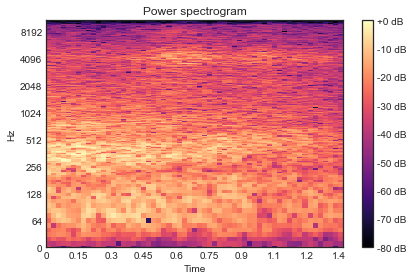

In [36]:
import librosa.display
import matplotlib.pyplot as plt
librosa.display.specshow(librosa.amplitude_to_db(D_left_Boeing_slices_train_matrix[1,:,:], ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

In [37]:
scales = np.arange(1,128)
time = np.arange(0,32000)
signal = Boeing_slices_train_matrix[1,:]
print(signal)
print(time)

dt = time[1] - time[0]
wavelet = 'cmor1.5-1.0'

[cfs, frequencies] = pywt.cwt(sst, scales, wavelet, dt)
power = (abs(cfs)) ** 2
period = 1. / frequencies
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]

newpower2 = np.flip(np.log2(power))
print(newpower2.shape)
time2 = np.arange(0,264)

plt.contourf(time2, np.log2(period), np.log2(power), np.log2(levels), extend='both',cmap='terrain')
plt.colorbar()
plt.axis(aspect='image');

[ -8104. -12943. -18698. ...      0.      0.   2251.]
[    0     1     2 ... 31997 31998 31999]


NameError: name 'sst' is not defined

In [502]:
new_sample = np.abs(librosa.core.ifgram(Boeing_slices_train_matrix[10,:], center=False))

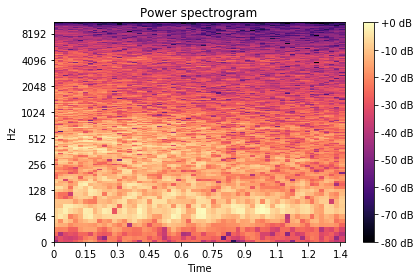

In [503]:
import librosa.display
import matplotlib.pyplot as plt
librosa.display.specshow(librosa.amplitude_to_db(new_sample[1,:,:], ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

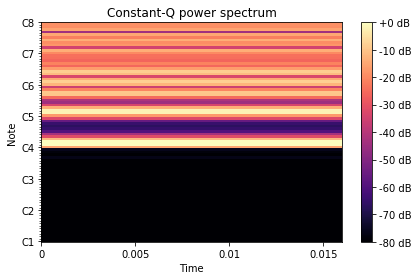

In [504]:

C = np.abs(librosa.cqt(new_sample[1,2,:], sr=32000))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=32000, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()